In [5]:
# ============================================================
# CELL 1: Imports and setup
# ============================================================
import flwr as fl
import matplotlib.pyplot as plt
import time
from flwr.common import parameters_to_ndarrays
from tensorflow.keras import models, layers

# Track metrics across rounds
history = {
    "round": [],
    "accuracy": [],
    "loss": [],
    "time": [],
    "class_acc": {}  # dict of lists per class
}
_round_start_time = None

print("✅ Imports loaded. Ready to run server code.")


✅ Imports loaded. Ready to run server code.


In [6]:
# ============================================================
# CELL 2: Model + strategy definition
# ============================================================
def evaluate_metrics_aggregation_fn(metrics):
    """Weighted average of evaluation metrics across clients."""
    global _round_start_time
    round_time = time.time() - _round_start_time
    history["time"].append(round_time)

    total_examples = sum(num_examples for num_examples, _ in metrics)

    # Weighted loss/accuracy
    weighted_loss = sum(num_examples * m["loss"] for num_examples, m in metrics) / total_examples
    weighted_acc = sum(num_examples * m["accuracy"] for num_examples, m in metrics) / total_examples

    round_number = len(history["round"]) + 1
    history["round"].append(round_number)
    history["loss"].append(weighted_loss)
    history["accuracy"].append(weighted_acc)

    # --- FIX: per-class accuracy aggregated across clients ---
    class_sums = {}
    class_counts = {}

    for num_examples, m in metrics:
        for k, v in m.items():
            if k.startswith("class_"):
                if k not in class_sums:
                    class_sums[k] = 0.0
                    class_counts[k] = 0
                class_sums[k] += num_examples * v
                class_counts[k] += num_examples

    # Store weighted average per-class accuracy
    for k in class_sums:
        avg_value = class_sums[k] / class_counts[k]
        if k not in history["class_acc"]:
            history["class_acc"][k] = []
        history["class_acc"][k].append(avg_value)

    print(f"📊 Round {round_number}: loss={weighted_loss:.4f}, acc={weighted_acc:.4f}, time={round_time:.2f}s")
    return {"loss": weighted_loss, "accuracy": weighted_acc}

class TimedFedAvg(fl.server.strategy.FedAvg):
    def configure_fit(self, server_round, parameters, client_manager):
        global _round_start_time
        _round_start_time = time.time()
        return super().configure_fit(server_round, parameters, client_manager)

def create_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(128, 128, 3)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(4, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

strategy = TimedFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

print("✅ Model and strategy defined.")


✅ Model and strategy defined.


In [7]:
# ============================================================
# CELL 3: Start server and capture global parameters
# ============================================================
print("🚀 Starting Flower Server...")
start_time = time.time()

# Container for final model parameters
final_parameters_container = {}

class CaptureFinalParameters(TimedFedAvg):
    def aggregate_fit(self, server_round, results, failures):
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)
        if aggregated_parameters is not None:
            final_parameters_container["parameters"] = aggregated_parameters
        return aggregated_parameters, aggregated_metrics

# Use strategy wrapper
capture_strategy = CaptureFinalParameters(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=2,
    min_evaluate_clients=2,
    min_available_clients=2,
    evaluate_metrics_aggregation_fn=evaluate_metrics_aggregation_fn,
)

fl.server.start_server(
    server_address="0.0.0.0:8080",
    strategy=capture_strategy,
    config=fl.server.ServerConfig(num_rounds=3),
)

total_time = time.time() - start_time
print(f"⏱ Total Training Time: {total_time:.2f} seconds")

# Store final parameters
final_parameters = final_parameters_container.get("parameters", None)
if final_parameters is None:
    print("⚠ Warning: No parameters were captured. Training might have failed.")
else:
    print("✅ Final global parameters captured.")


	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flower-superlink` CLI command to start a SuperLink as shown below:

		$ flower-superlink --insecure

	To view usage and all available options, run:

		$ flower-superlink --help

	Using `start_server()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower server, config: num_rounds=3, no round_timeout
INFO:flwr:Starting Flower server, config: num_rounds=3, no round_timeout


🚀 Starting Flower Server...


INFO :      Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO:flwr:Flower ECE: gRPC server running (3 rounds), SSL is disabled
INFO :      [INIT]
INFO:flwr:[INIT]
INFO :      Requesting initial parameters from one random client
INFO:flwr:Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO:flwr:Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO:flwr:Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO:flwr:Evaluation returned no results (`None`)
INFO :      
INFO:flwr:
INFO :      [ROUND 1]
INFO:flwr:[ROUND 1]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)
INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: st

📊 Round 1: loss=0.9119, acc=0.5931, time=77.14s


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_fit: strategy sampled 2 clients (out of 2)


📊 Round 2: loss=0.7123, acc=0.6687, time=93.03s


INFO :      aggregate_fit: received 2 results and 0 failures
INFO:flwr:aggregate_fit: received 2 results and 0 failures
INFO :      configure_evaluate: strategy sampled 2 clients (out of 2)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 2)
INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 3 round(s) in 245.45s
INFO:flwr:Run finished 3 round(s) in 245.45s
INFO :      	History (loss, distributed):
INFO:flwr:	History (loss, distributed):
INFO :      		round 1: 0.9119060039520264
INFO:flwr:		round 1: 0.9119060039520264
INFO :      		round 2: 0.712283730506897
INFO:flwr:		round 2: 0.712283730506897
INFO :      		round 3: 0.5693004727363586
INFO:flwr:		round 3: 0.5693004727363586
INFO :      	History (metrics, distributed, evaluate):
INFO:flwr:	History (metrics, distributed, evaluate):
INFO :      	{'accur

📊 Round 3: loss=0.5693, acc=0.7529, time=75.25s
⏱ Total Training Time: 276.04 seconds
✅ Final global parameters captured.


💾 Saved final model to federated_alzheimer_model_2.h5


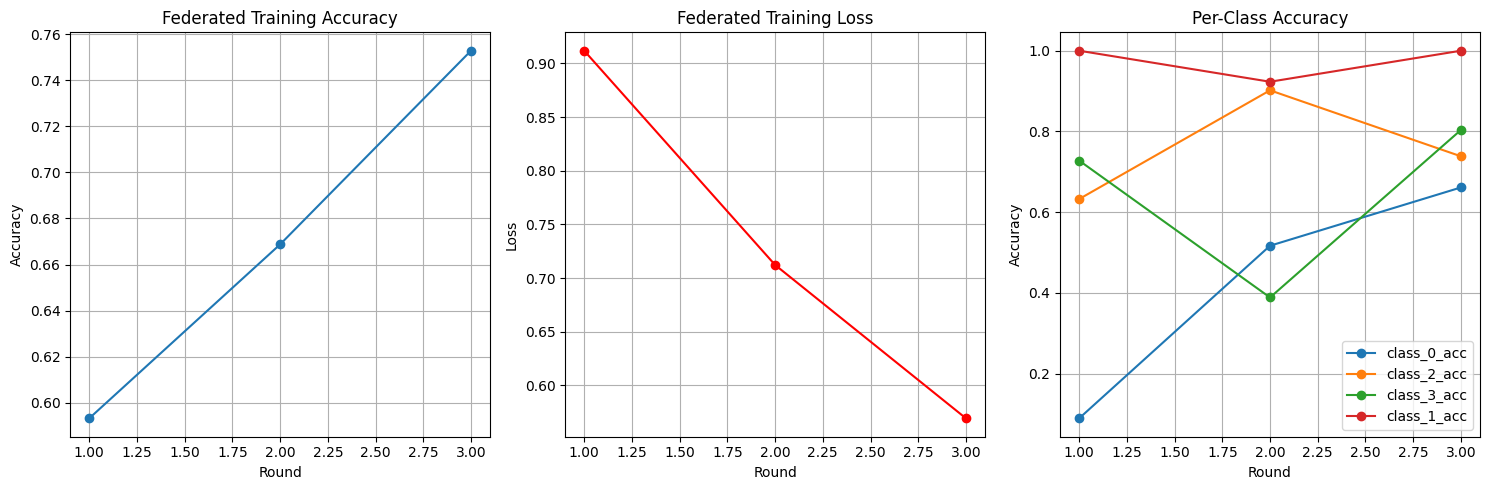

In [8]:
# ============================================================
# CELL 4: Save final model & plot metrics
# ============================================================
from flwr.common import parameters_to_ndarrays
import numpy as np

if final_parameters is None:
    raise RuntimeError("❌ No final parameters found. Run Cell 3 again after successful training.")

# --- 1. Rebuild global model and load weights ---
global_model = create_cnn_model()
global_weights = parameters_to_ndarrays(final_parameters)
global_model.set_weights(global_weights)

# --- 2. Save trained global model ---
global_model.save("federated_alzheimer_model_2.h5")
print("💾 Saved final model to federated_alzheimer_model_2.h5")

# --- 3. Plot metrics ---
if len(history["round"]) > 0:
    rounds = history["round"]
    plt.figure(figsize=(15, 5))

    # Global accuracy
    plt.subplot(1, 3, 1)
    plt.plot(rounds, history["accuracy"], marker="o")
    plt.title("Federated Training Accuracy")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.grid()

    # Global loss
    plt.subplot(1, 3, 2)
    plt.plot(rounds, history["loss"], marker="o", color="red")
    plt.title("Federated Training Loss")
    plt.xlabel("Round")
    plt.ylabel("Loss")
    plt.grid()

    # Per-class accuracy
    plt.subplot(1, 3, 3)
    for class_label, acc_values in history["class_acc"].items():
        plt.plot(rounds[:len(acc_values)], acc_values, marker="o", label=class_label)
    plt.title("Per-Class Accuracy")
    plt.xlabel("Round")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
else:
    print("⚠ No metrics available to plot.")
